# Star Wars Original Trilogy - Network Analysis
This notebook creates and visualizes two networks from the Star Wars scripts:
1. Character-Character network (weighted by shared scenes)
2. Character-Location bipartite network (weighted by appearance frequency)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np

# Load the data
data_dir = Path("data")

# Load character connections
with open(data_dir / "character_connections.json", "r") as f:
    character_connections = json.load(f)

# Load location-character data
with open(data_dir / "location_characters.json", "r") as f:
    location_characters = json.load(f)

print(f"Loaded {len(character_connections)} characters")
print(f"Loaded {len(location_characters)} locations")

# Show sample data
print("\nSample characters and their connections:")
for i, (char, connections) in enumerate(list(character_connections.items())[:3]):
    print(f"\n{char}:")
    for connected_char, weight in sorted(
        connections.items(), key=lambda x: x[1], reverse=True
    )[:3]:
        print(f"  -> {connected_char}: {weight} scenes")

Loaded 94 characters
Loaded 40 locations

Sample characters and their connections:

Announcer:
  -> C-3PO: 2 scenes
  -> Han Solo: 2 scenes
  -> Leia Organa: 2 scenes

Area:
  -> Han Solo: 1 scenes
  -> Luke Skywalker: 1 scenes

Assistant Officer:
  -> Deck Officer: 1 scenes
  -> Han Solo: 1 scenes


## Network 1: Character-Character Connections
Nodes are characters, edges are weighted by the number of scenes they share together.

In [2]:
# Create character-character network
G_characters = nx.Graph()

# Add nodes and edges
for char, connections in character_connections.items():
    G_characters.add_node(char)

    for connected_char, weight in connections.items():
        # Only add edge once (since it's bidirectional)
        if char < connected_char:  # Avoid duplicates
            G_characters.add_edge(char, connected_char, weight=weight)

print("Character Network:")
print(f"  Nodes: {G_characters.number_of_nodes()}")
print(f"  Edges: {G_characters.number_of_edges()}")
print(f"  Density: {nx.density(G_characters):.3f}")

# Network statistics
print("\nTop 10 most connected characters by degree:")
degree_dict = dict(G_characters.degree(weight="weight"))
for char, degree in sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {char}: {degree}")

Character Network:
  Nodes: 94
  Edges: 247
  Density: 0.057

Top 10 most connected characters by degree:
  Han Solo: 154
  Luke Skywalker: 154
  Leia Organa: 132
  C-3PO: 128
  Darth Vader: 53
  Obi-Wan Kenobi: 48
  Lando Calrissian: 35
  Biggs Darklighter: 21
  Grand Moff Tarkin: 19
  Red Leader: 16


### Visualize Character Network with Force-Directed Layout

Saved character network visualization to figures/character_network.png


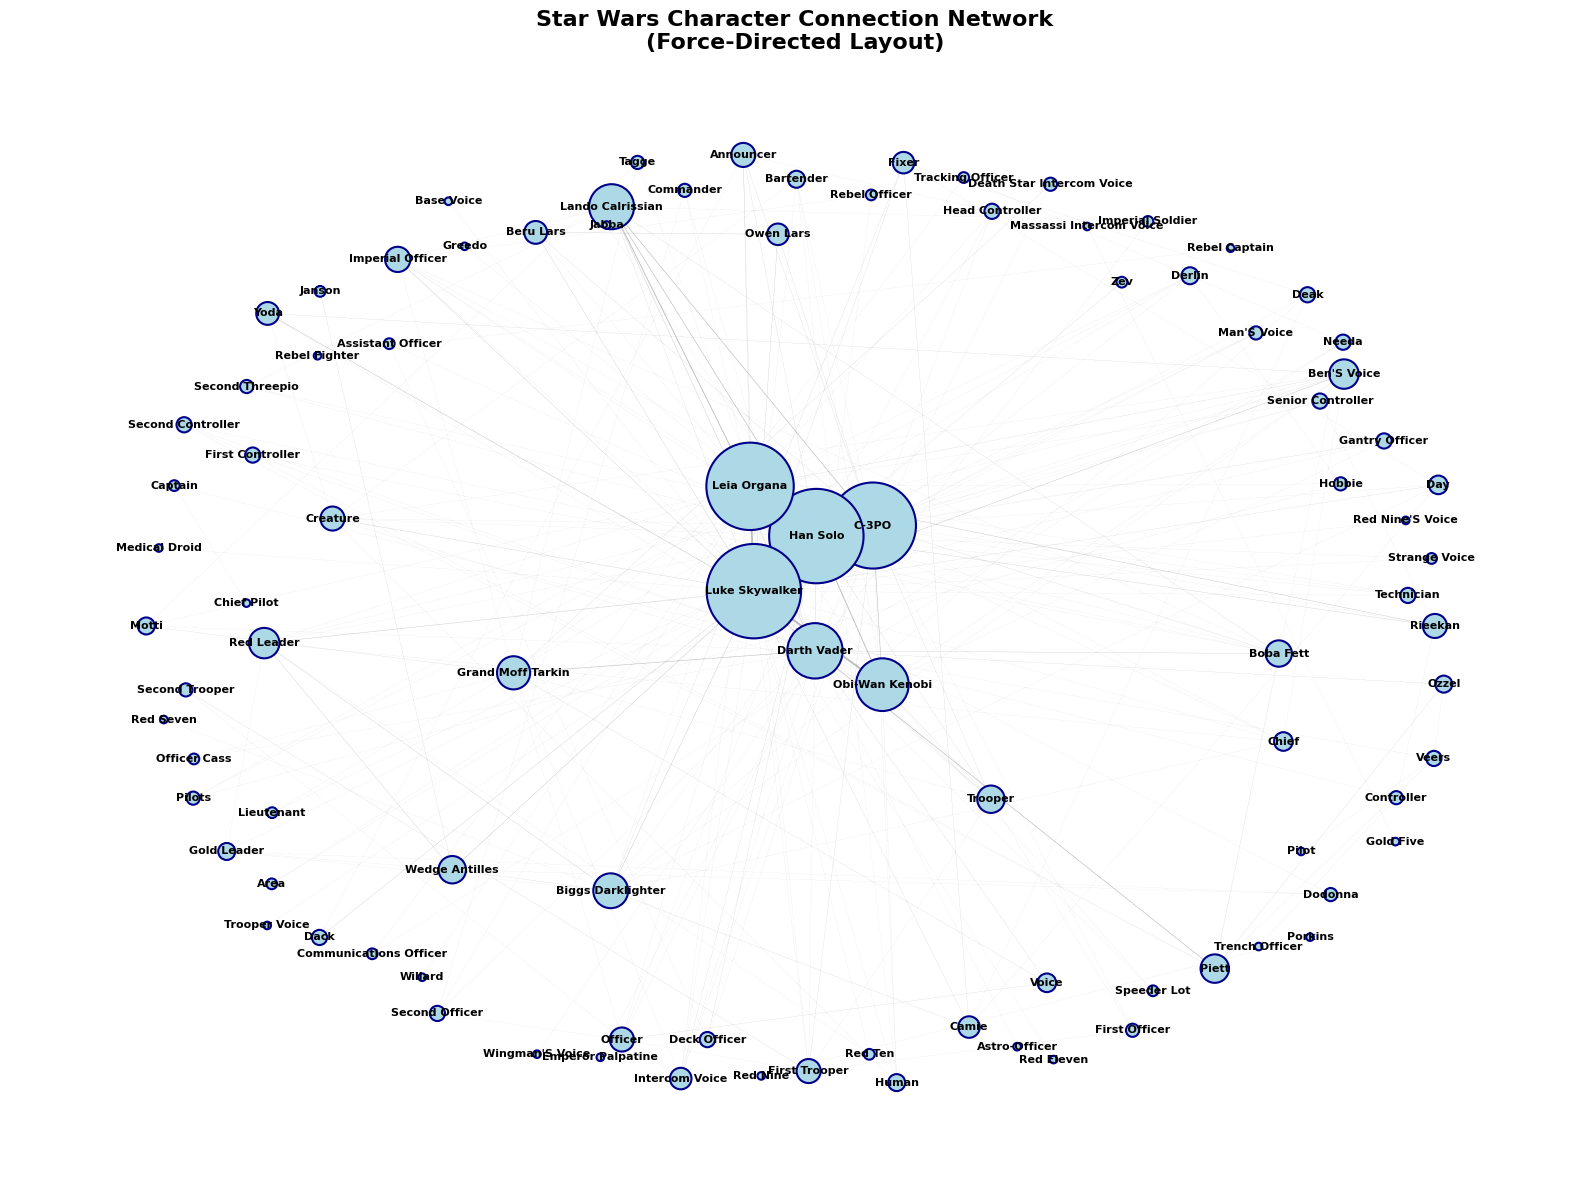

In [3]:
# Create figure
fig, ax = plt.subplots(figsize=(16, 12))

# Use spring layout (force-directed) with seed for reproducibility
pos = nx.spring_layout(
    G_characters,
    k=2,  # Optimal distance between nodes
    iterations=50,
    seed=42,
    weight="weight",
)

# Prepare node sizes based on degree
node_sizes = [
    G_characters.degree(node, weight="weight") * 30 for node in G_characters.nodes()
]

# Prepare edge widths based on weight
edges = G_characters.edges()
weights = [G_characters[u][v]["weight"] for u, v in edges]
max_weight = max(weights) if weights else 1
edge_widths = [w / max_weight * 3 for w in weights]

# Draw the network
nx.draw_networkx_nodes(
    G_characters,
    pos,
    node_size=node_sizes,
    node_color="lightblue",
    edgecolors="darkblue",
    linewidths=1.5,
    ax=ax,
)

nx.draw_networkx_edges(
    G_characters, pos, width=edge_widths, alpha=0.5, edge_color="gray", ax=ax
)

nx.draw_networkx_labels(G_characters, pos, font_size=8, font_weight="bold", ax=ax)

ax.set_title(
    "Star Wars Character Connection Network\n(Force-Directed Layout)",
    fontsize=16,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
plt.savefig("figures/character_network.png", dpi=300, bbox_inches="tight")
print("Saved character network visualization to figures/character_network.png")
plt.show()

## Network 2: Character-Location Bipartite Network
Nodes are both characters and locations. Edges connect characters to locations they appear in.

In [4]:
# Create character-location bipartite network
G_bipartite = nx.Graph()

# Track node types for coloring
character_nodes = set()
location_nodes = set()

# Add character nodes
for char in character_connections.keys():
    G_bipartite.add_node(char, node_type="character")
    character_nodes.add(char)

# Add location nodes and edges
for location, characters in location_characters.items():
    G_bipartite.add_node(location, node_type="location")
    location_nodes.add(location)

    # Add edges from each character to this location
    for char in characters:
        if char in character_nodes:  # Only if character is in the main network
            weight = 1  # Each appearance counts as 1
            # If edge already exists, increment weight
            if G_bipartite.has_edge(char, location):
                G_bipartite[char][location]["weight"] += weight
            else:
                G_bipartite.add_edge(char, location, weight=weight)

print("Bipartite Network:")
print(f"  Total Nodes: {G_bipartite.number_of_nodes()}")
print(f"  Character Nodes: {len(character_nodes)}")
print(f"  Location Nodes: {len(location_nodes)}")
print(f"  Edges: {G_bipartite.number_of_edges()}")

# Show most connected locations
print("\nTop 10 most visited locations:")
location_degrees = {loc: G_bipartite.degree(loc) for loc in location_nodes}
for location, degree in sorted(
    location_degrees.items(), key=lambda x: x[1], reverse=True
)[:10]:
    print(f"  {location}: {degree} characters")

Bipartite Network:
  Total Nodes: 134
  Character Nodes: 94
  Location Nodes: 40
  Edges: 211

Top 10 most visited locations:
  Death Star: 24 characters
  Tatooine: 17 characters
  Massassi Outpost: 15 characters
  Rebel Base: 15 characters
  Hoth: 12 characters
  Cloud City: 11 characters
  Vader's Star Destroyer: 9 characters
  Main Hangar: 8 characters
  Millennium Falcon: 7 characters
  Dagobah: 6 characters


### Visualize Bipartite Network with Force-Directed Layout

Saved bipartite network visualization to figures/bipartite_network.png


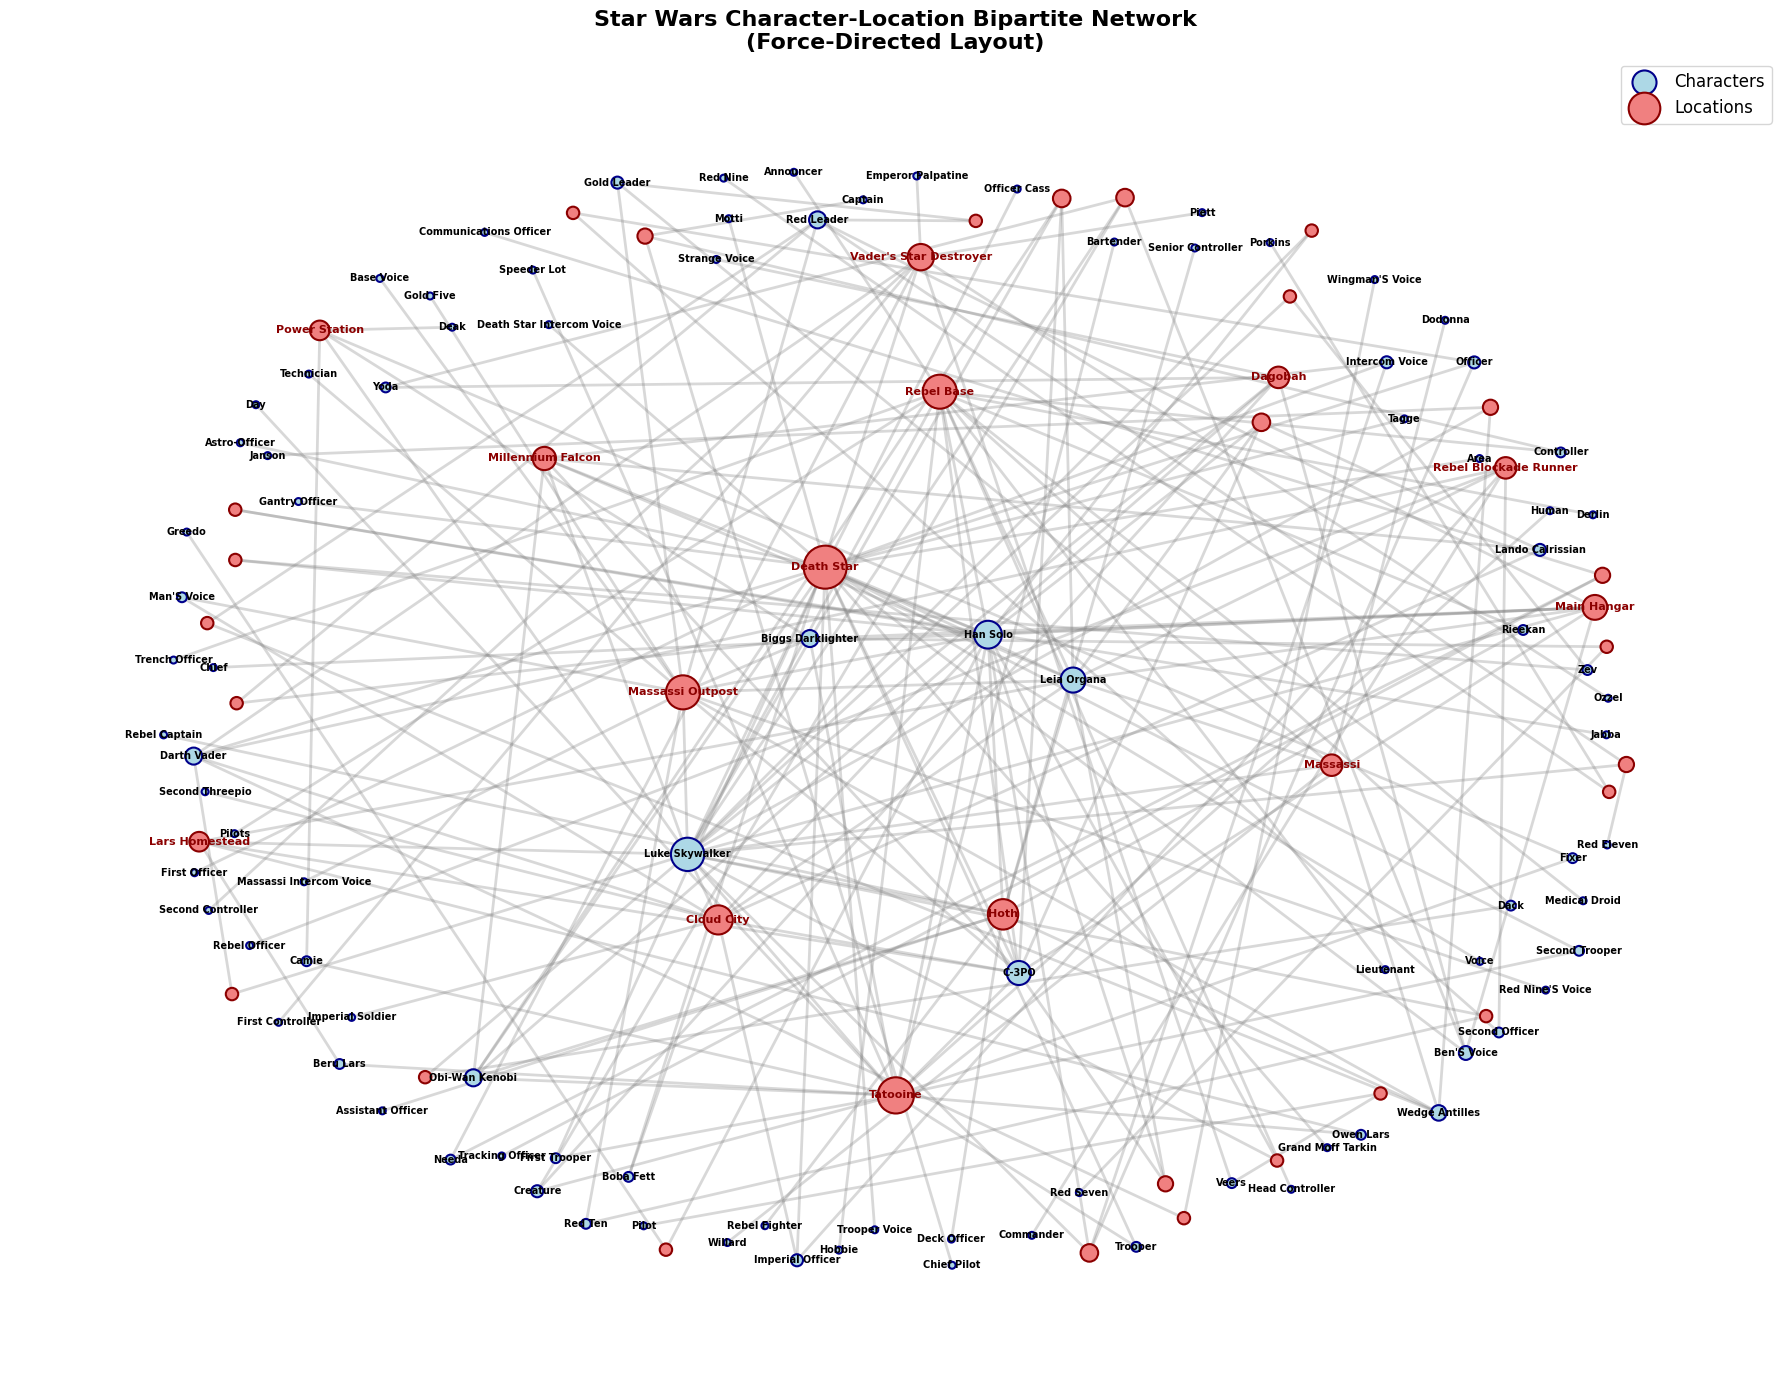

In [5]:
# Create figure
fig, ax = plt.subplots(figsize=(18, 14))

# Use spring layout for bipartite network
pos_bipartite = nx.spring_layout(
    G_bipartite, k=1.5, iterations=50, seed=42, weight="weight"
)

# Separate nodes by type
char_nodes = [node for node in G_bipartite.nodes() if node in character_nodes]
loc_nodes = [node for node in G_bipartite.nodes() if node in location_nodes]

# Node sizes
char_node_sizes = [G_bipartite.degree(node) * 25 for node in char_nodes]
loc_node_sizes = [G_bipartite.degree(node) * 40 for node in loc_nodes]

# Draw character nodes
nx.draw_networkx_nodes(
    G_bipartite,
    pos_bipartite,
    nodelist=char_nodes,
    node_size=char_node_sizes,
    node_color="lightblue",
    edgecolors="darkblue",
    linewidths=1.5,
    label="Characters",
    ax=ax,
)

# Draw location nodes
nx.draw_networkx_nodes(
    G_bipartite,
    pos_bipartite,
    nodelist=loc_nodes,
    node_size=loc_node_sizes,
    node_color="lightcoral",
    edgecolors="darkred",
    linewidths=1.5,
    label="Locations",
    ax=ax,
)

# Draw edges
edges_bi = G_bipartite.edges()
weights_bi = [G_bipartite[u][v]["weight"] for u, v in edges_bi]
max_weight_bi = max(weights_bi) if weights_bi else 1
edge_widths_bi = [w / max_weight_bi * 2 for w in weights_bi]

nx.draw_networkx_edges(
    G_bipartite,
    pos_bipartite,
    width=edge_widths_bi,
    alpha=0.3,
    edge_color="gray",
    ax=ax,
)

# Draw labels (only for major nodes to avoid clutter)
# Draw all character labels
nx.draw_networkx_labels(
    G_bipartite,
    pos_bipartite,
    labels={node: node if node in char_nodes else "" for node in G_bipartite.nodes()},
    font_size=7,
    font_weight="bold",
    ax=ax,
)

# Draw location labels for highly connected locations only
high_degree_locs = {loc: loc for loc, deg in location_degrees.items() if deg >= 5}
nx.draw_networkx_labels(
    G_bipartite,
    pos_bipartite,
    labels=high_degree_locs,
    font_size=8,
    font_color="darkred",
    font_weight="bold",
    ax=ax,
)

ax.set_title(
    "Star Wars Character-Location Bipartite Network\n(Force-Directed Layout)",
    fontsize=16,
    fontweight="bold",
)
ax.legend(scatterpoints=1, fontsize=12)
ax.axis("off")
plt.tight_layout()
plt.savefig("figures/bipartite_network.png", dpi=300, bbox_inches="tight")
print("Saved bipartite network visualization to figures/bipartite_network.png")
plt.show()

## Network Analysis Summary

In [6]:
# Character Network Statistics
print("=" * 60)
print("CHARACTER NETWORK STATISTICS")
print("=" * 60)

print("\nBasic Metrics:")
print(f"  Number of Characters: {G_characters.number_of_nodes()}")
print(f"  Number of Connections: {G_characters.number_of_edges()}")
print(f"  Network Density: {nx.density(G_characters):.4f}")
print(
    f"  Average Degree: {sum(dict(G_characters.degree()).values()) / G_characters.number_of_nodes():.2f}"
)

# Connected components
components = list(nx.connected_components(G_characters))
print(f"  Connected Components: {len(components)}")
largest_cc = max(components, key=len)
print(
    f"  Largest Component Size: {len(largest_cc)} ({len(largest_cc)/G_characters.number_of_nodes()*100:.1f}%)"
)

print("\nMost Connected Characters (by weighted degree):")
weighted_degrees = dict(G_characters.degree(weight="weight"))
for i, (char, degree) in enumerate(
    sorted(weighted_degrees.items(), key=lambda x: x[1], reverse=True)[:10], 1
):
    print(f"  {i:2d}. {char:25s} - {degree:3.0f}")

print(
    f"\nAverage path length (largest component): {nx.average_shortest_path_length(G_characters.subgraph(largest_cc)):.2f}"
)
print(f"Diameter (largest component): {nx.diameter(G_characters.subgraph(largest_cc))}")

# Bipartite Network Statistics
print("\n" + "=" * 60)
print("BIPARTITE NETWORK STATISTICS")
print("=" * 60)

print("\nBasic Metrics:")
print(f"  Number of Characters: {len(character_nodes)}")
print(f"  Number of Locations: {len(location_nodes)}")
print(f"  Total Nodes: {G_bipartite.number_of_nodes()}")
print(f"  Total Connections: {G_bipartite.number_of_edges()}")

print("\nMost Visited Locations:")
for i, (location, degree) in enumerate(
    sorted(location_degrees.items(), key=lambda x: x[1], reverse=True)[:10], 1
):
    chars_at_loc = location_characters[location]
    print(f"  {i:2d}. {location:40s} - {degree:2d} characters")

print("\nCharacters with Most Locations:")
char_location_counts = {char: G_bipartite.degree(char) for char in character_nodes}
for i, (char, count) in enumerate(
    sorted(char_location_counts.items(), key=lambda x: x[1], reverse=True)[:10], 1
):
    print(f"  {i:2d}. {char:25s} - {count:2d} locations")

CHARACTER NETWORK STATISTICS

Basic Metrics:
  Number of Characters: 94
  Number of Connections: 247
  Network Density: 0.0565
  Average Degree: 5.26
  Connected Components: 4
  Largest Component Size: 88 (93.6%)

Most Connected Characters (by weighted degree):
   1. Han Solo                  - 154
   2. Luke Skywalker            - 154
   3. Leia Organa               - 132
   4. C-3PO                     - 128
   5. Darth Vader               -  53
   6. Obi-Wan Kenobi            -  48
   7. Lando Calrissian          -  35
   8. Biggs Darklighter         -  21
   9. Grand Moff Tarkin         -  19
  10. Red Leader                -  16

Average path length (largest component): 2.64
Diameter (largest component): 7

BIPARTITE NETWORK STATISTICS

Basic Metrics:
  Number of Characters: 94
  Number of Locations: 40
  Total Nodes: 134
  Total Connections: 211

Most Visited Locations:
   1. Death Star                               - 24 characters
   2. Tatooine                                 -

## Export Network Data

In [7]:
# Save networks to GML format for further analysis
output_dir = Path("networks")
output_dir.mkdir(exist_ok=True)

# Save character network
char_net_path = output_dir / "character_network.gml"
nx.write_gml(G_characters, str(char_net_path))
print(f"Saved character network to {char_net_path}")

# Save bipartite network
bip_net_path = output_dir / "bipartite_network.gml"
nx.write_gml(G_bipartite, str(bip_net_path))
print(f"Saved bipartite network to {bip_net_path}")

# Export basic statistics to JSON
stats = {
    "character_network": {
        "nodes": G_characters.number_of_nodes(),
        "edges": G_characters.number_of_edges(),
        "density": float(nx.density(G_characters)),
        "components": len(list(nx.connected_components(G_characters))),
        "average_degree": float(
            sum(dict(G_characters.degree()).values()) / G_characters.number_of_nodes()
        ),
    },
    "bipartite_network": {
        "total_nodes": G_bipartite.number_of_nodes(),
        "character_nodes": len(character_nodes),
        "location_nodes": len(location_nodes),
        "edges": G_bipartite.number_of_edges(),
    },
}

stats_path = output_dir / "network_statistics.json"
with open(stats_path, "w") as f:
    json.dump(stats, f, indent=2)
print(f"Saved network statistics to {stats_path}")

Saved character network to networks/character_network.gml
Saved bipartite network to networks/bipartite_network.gml
Saved network statistics to networks/network_statistics.json
